In [80]:
#ipython stuf
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [114]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import fancyimpute
import sklearn as skl

In [82]:
#objective:
#predict whether a passenger died or lived based on the below features
#notes on features here: https://www.kaggle.com/c/titanic/data
#example algorithms here

#survival = 1

In [115]:
#todo:

#reading
## - https://rpubs.com/spring16/184493
## - https://gormanalysis.com/logistic-regression-fundamentals/
## - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

#feature engineering:
## - smart imputation with MICE
### - compare imputation results on a pdf 
## - reincorporate title 
## - cabin (1st class passengers only) --> deck transformation
## - profession 
## - french vs english port (c = cherbourg, q = queenstown, s = southampton)

#model building:
## logistic regression in skl
### - dummy vars for embarkment 
### - model built
### - model submission
### - cross-validation
### - re-submission
## svm in skl
### - model built

# implementation in tensorflow and in scikitlearn

In [84]:
df = pd.read_csv('train.csv')

In [85]:
def title_s(name):
    m = re.search(r'\b,\s(\w+)', name).group(1)
    return m

In [86]:
df['Title'] = df['Name'].apply(title_s, 1)

In [87]:
df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Jonkheer      1
Ms            1
Lady          1
the           1
Don           1
Mme           1
Capt          1
Sir           1
Name: Title, dtype: int64

Don't think I can do much with title given it's such a small portion of the feature.

In [88]:
df[(df.Title == 'Master') & (df.Age < 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S,Master
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,Master
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S,Master
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C,Master
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S,Master


All kids under 1 with the honorific "Master" survived, which is obv higher then the rate of survival in pop. But probably coincidental given children survival rate.

In [89]:
#some basic transforms
gend = {'male': 0, 'female' : 1}
df['Sex'] = df['Sex'].map(gend)
df['agefare'] = df['Age']*df['Fare']
df['fam_size'] = df['SibSp'] + df['Parch']
df['fare_p_person'] = df['Fare'] / df['fam_size']

In [90]:
df.ix[(df.Cabin.notnull()) & (df.Pclass != 1), :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,agefare,fam_size,fare_p_person
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,16.7000,G6,S,Miss,66.8000,2,8.350000
21,22,1,2,"Beesley, Mr. Lawrence",0,34.0,0,0,248698,13.0000,D56,S,Mr,442.0000,0,inf
66,67,1,2,"Nye, Mrs. (Elizabeth Ramell)",1,29.0,0,0,C.A. 29395,10.5000,F33,S,Mrs,304.5000,0,inf
75,76,0,3,"Moen, Mr. Sigurd Hansen",0,25.0,0,0,348123,7.6500,F G73,S,Mr,191.2500,0,inf
123,124,1,2,"Webber, Miss. Susan",1,32.5,0,0,27267,13.0000,E101,S,Miss,422.5000,0,inf
128,129,1,3,"Peter, Miss. Anna",1,NaN,1,1,2668,22.3583,F E69,C,Miss,NaN,2,11.179150
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",0,36.5,0,2,230080,26.0000,F2,S,Mr,949.0000,2,13.000000
183,184,1,2,"Becker, Master. Richard F",0,1.0,2,1,230136,39.0000,F4,S,Master,39.0000,3,13.000000
193,194,1,2,"Navratil, Master. Michel M",0,3.0,1,1,230080,26.0000,F2,S,Master,78.0000,2,13.000000
205,206,0,3,"Strom, Miss. Telma Matilda",1,2.0,0,1,347054,10.4625,G6,S,Miss,20.9250,1,10.462500


How can somebody be in a cabin and not in 1st class? And how is / why is fare infinite and how to treat that.

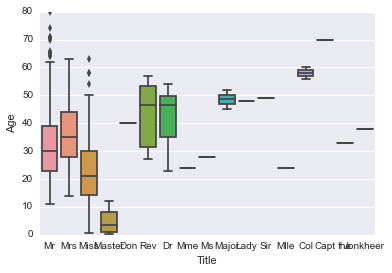

In [91]:
ax = sns.boxplot(x=df.Title, y=df.Age)

In [92]:
df_t = df.ix[:, ['Age', 'Fare', 'Sex']]
for x in df_t.columns:
    try:
        df_t[x].apply(lambda x: float(x))
    except ValueError as e:
        print e

In [108]:
filled_KNN5 = pd.Series(fancyimpute.KNN(k=5).complete(df_t)[:, 0], index=df_t.index, name='filled_age')
df_t.join(filled_KNN5)

Imputing row 1/891 with 0 missing, elapsed time: 0.089
Imputing row 101/891 with 0 missing, elapsed time: 0.090
Imputing row 201/891 with 0 missing, elapsed time: 0.090
Imputing row 301/891 with 1 missing, elapsed time: 0.091
Imputing row 401/891 with 0 missing, elapsed time: 0.091
Imputing row 501/891 with 0 missing, elapsed time: 0.092
Imputing row 601/891 with 0 missing, elapsed time: 0.092
Imputing row 701/891 with 0 missing, elapsed time: 0.093
Imputing row 801/891 with 0 missing, elapsed time: 0.093


In [116]:
#replace age with imputed values from fancyimpute.KNN
df['Age'] = filled_KNN5

In [125]:
#create dummy variables for classifiers (embarkemnt)
dummies = pd.get_dummies(df['Embarked'])

In [140]:
#exclude titles for now, join dummies and keep only releant columns for model usage
df_train = df.ix[:,['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'agefare', 'fam_size']].join(dummies)